In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import ta

In [ ]:
ticker = 'AAPL'
data = yf.download(ticker, start='2014-01-01', end='2024-01-01')
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                                        
2014-01-02  17.234295  19.754642  19.893929  19.715000  19.845715  234684800
2014-01-03  16.855730  19.320715  19.775000  19.301071  19.745001  392467600
2014-01-06  16.947647  19.426071  19.528570  19.057142  19.194643  412610800
2014-01-07  16.826441  19.287144  19.498571  19.211430  19.440001  317209200
2014-01-08  16.932999  19.409286  19.484285  19.238930  19.243214  258529600


In [ ]:
import ta.momentum
import ta.trend

data['SMA_50'] = ta.trend.sma_indicator(data['Close'].squeeze(), window=50)
data['SMA_200'] = ta.trend.sma_indicator(data['Close'].squeeze(), window=200)
data['RSI'] = ta.momentum.rsi(data['Close'].squeeze(), window=14)
data['MACD'] = ta.trend.macd(data['Close'].squeeze())
data['MACD_signal'] = ta.trend.macd_signal(data['Close'].squeeze())

data = data.dropna()
print(data.tail())

Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
Date                                                                     
2023-12-22  192.656174  193.600006  195.410004  192.970001  195.179993   
2023-12-26  192.108856  193.050003  193.889999  192.830002  193.610001   
2023-12-27  192.208374  193.149994  193.500000  191.089996  192.490005   
2023-12-28  192.636276  193.580002  194.660004  193.169998  194.139999   
2023-12-29  191.591385  192.529999  194.399994  191.729996  193.899994   

Price         Volume      SMA_50     SMA_200        RSI      MACD MACD_signal  
Ticker          AAPL                                                           
Date                                                                           
2023-12-22  37122800  185.398801  178.649100  54.609714  2.636317    3.236689  
2023-12-26  28919300  185.682801  178.871851  53.026883  2.306308    3.050613  
2023-12

In [ ]:
features = ['Close', 'SMA_50', 'SMA_200', 'RSI', 'MACD', 'MACD_signal']
data = data[features]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [ ]:
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:(i + n_steps_in)])
        y.append(data[(i + n_steps_in):(i + n_steps_in + n_steps_out), 0])
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 60, 5
X, y = create_sequences(scaled_data, n_steps_in, n_steps_out)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Data shape:", data.shape)
print("Scaled data shape:", scaled_data.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Data shape: (2317, 6)
Scaled data shape: (2317, 6)
X shape: (2253, 60, 6)
y shape: (2253, 5)
X_train shape: (1802, 60, 6)
y_train shape: (1802, 5)
X_test shape: (451, 60, 6)
y_test shape: (451, 5)


In [ ]:
def create_model(units, dropout, learning_rate):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(n_steps_in, len(features))),
        Dropout(dropout),
        LSTM(units),
        Dropout(dropout),
        Dense(n_steps_out)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Define hyperparameter grid
# param_grid = {
#     'units': [50, 75, 100],
#     'dropout': [0.1, 0.2],
#     'learning_rate': [0.001, 0.05, 0.01]
# }

param_grid = {
    'units': [76],
    'dropout': [0.08],
    'learning_rate': [0.01]
}

# Perform grid search
best_score = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    model = create_model(**params)
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )
    val_loss = min(history.history['val_loss'])

    if val_loss < best_score:
        best_score = val_loss
        best_params = params

print("Best parameters:", best_params)
print("Best validation loss:", best_score)

# Train final model with best parameters
best_model = create_model(**best_params)
best_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters: {'dropout': 0.08, 'learning_rate': 0.01, 'units': 76}
Best validation loss: 0.0006794604705646634
Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0730
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.8563e-04
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3304e-04
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.7601e-04
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8025e-04
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.6946e-04
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.4336e-04
Epoch 13/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.3

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM MSE: 25.49710307319747 MAE: 3.9517880323456565
LSTM R² Score: 0.9242688137602331


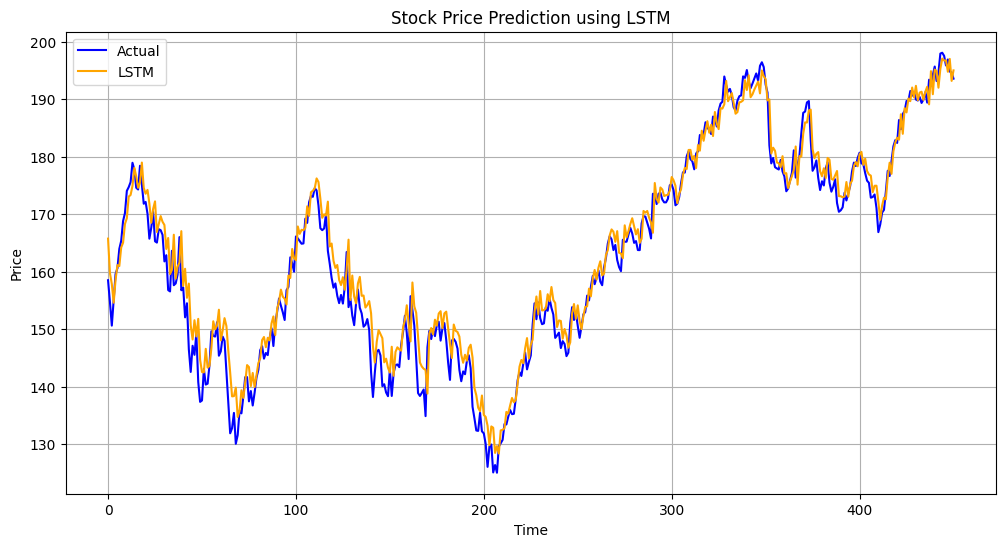

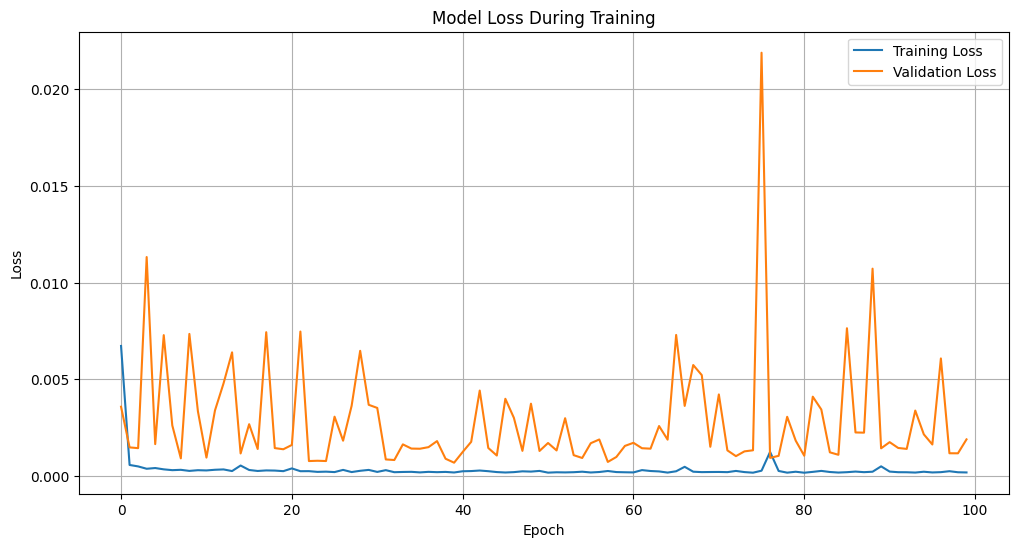

In [ ]:
lstm_pred = best_model.predict(X_test)

# Create scaler for Close price only
close_scaler = MinMaxScaler()
close_scaler.fit(data[['Close']])

# Inverse transform predictions and actual values
lstm_pred_inv = close_scaler.inverse_transform(lstm_pred)
y_test_inv = close_scaler.inverse_transform(y_test)

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    return mse, mae

lstm_mse, lstm_mae = calculate_metrics(y_test_inv, lstm_pred_inv)
print("LSTM MSE:", lstm_mse, "MAE:", lstm_mae)

from sklearn.metrics import r2_score

# Calculate R-squared for LSTM predictions
r2_lstm = r2_score(y_test_inv.flatten(), lstm_pred_inv.flatten())
print(f"LSTM R² Score: {r2_lstm}")


# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:, 0], label='Actual', color='blue')
plt.plot(lstm_pred_inv[:, 0], label='LSTM', color='orange')
plt.legend()
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#significance-f
#t-stat
#p-value
#fundamental factor models
#economic factor models